In [30]:
from typing import List
from collections import Counter

def majority_vote(labels: List[str]) -> str:
    """Исходит из того, что метки упорядочен  от ближайшей до самой удаленной"""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]

    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])
    if num_winners == 1:
        return winner # Уникальный победитель, поэтому вернуть его
    else: 
        return majority_vote(labels[:-1]) # Попытаться снова без самой удаленной
    
# Равное число голосов, поэтому взять первые 4, затем 'b'
assert majority_vote(['a','b','c','b','a']) == 'b'

### Классификатор

In [52]:
from typing import NamedTuple
from theory.linear_algebra import Vector, distance

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:
    
    # Упорядочить помеченные точки от ближайшей до самой дальней
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))
    
    # Отыскать метки для k ближайших
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    return majority_vote(k_nearest_labels)

### Набор данных о цветках ириса

In [35]:
import requests

data = requests.get(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
)
with open('iris.data','w') as f:
    f.write(data.text)

In [36]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    # Длина чашелистика, ширина чашелистика, длина лепестка, ширина лепестка, класс
    measurements = [float(value) for value in row[:-1]]

    # Класс чашелистика
    label = row[-1].split("-")[-1]

    return LabeledPoint(measurements, label)


with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader if len(row)>0]

points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)


### Диаграммы рассеяния для каждой из шести пар данных

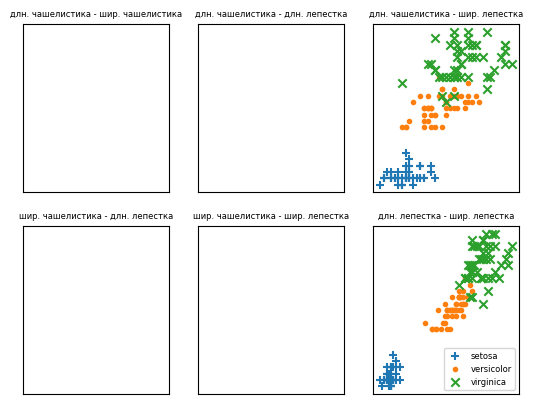

In [37]:
from matplotlib import pyplot as plt

metrics = ['длн. чашелистика', 'шир. чашелистика', 'длн. лепестка', 'шир. лепестка']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} - {metrics[j]}", fontsize=6)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

    for mark, (species, points) in zip(marks, points_by_species.items()):
        xs = [point[i] for point in points]
        ys = [point[j] for point in points]
        ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size':6})
plt.show()

### Разделим данные на тестовый и тренировочный наборы

In [53]:
import random
from theory.machine_learning import split_data

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)

assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

### Возьмем k = 5


In [39]:
from typing import Tuple

# Отследить число раз, когда мы будем видеть (предсказано, фактически)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


## Проклятие размерности

In [40]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

In [41]:
import tqdm
import numpy as np
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Проклятие размерности"):
    distances = random_distances(dim, 10000)
    avg_distances.append(np.mean(distances))
    min_distances.append(min(distances))

min_avg_ratio = [min_dist / avg_dist
                 for min_dist, avg_dist in zip(min_distances, avg_distances)]

Проклятие размерности: 100%|██████████| 100/100 [00:11<00:00,  8.70it/s]
